In [1]:
from utils import *
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Carregar treino
X = []
y = []

dirs = ['audios\\amostras_treino', 'audios\\minhas_treino']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        coefs = get_mfcc_coefs(path)
        X.append(coefs)
        y.append(label)
    label=1

X = np.array(X)
y = np.array(y)
y_c = to_categorical(y, 2)

print(X.shape)
print(y.shape)
print(y_c.shape)

# Scaler
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

# Carregar teste
X_test = []
y_test = []

dirs = ['audios\\amostras_teste', 'audios\\minha_teste']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        coefs = get_mfcc_coefs(path)
        X_test.append(coefs)
        y_test.append(label)
    label=1

X_test = np.array(X_test)
y_test = np.array(y_test)
y_c_test = to_categorical(y_test, 2)

X_test = scaler.transform(X_test)

print(X_test.shape)
print(y_test.shape)
print(y_c_test.shape)

# Carregar validacao
X_validacao = []
y_validacao = []

dirs = ['audios\\amostras_validacao', 'audios\\minhas_validacao']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        coefs = get_mfcc_coefs(path)
        X_validacao.append(coefs)
        y_validacao.append(label)
    label=1

X_validacao = np.array(X_validacao)
y_validacao = np.array(y_validacao)
y_c_validacao = to_categorical(y_validacao, 2)

X_validacao = scaler.transform(X_validacao)

print(X_validacao.shape)
print(y_validacao.shape)
print(y_c_validacao.shape)

(90, 3600)
(90,)
(90, 2)
(45, 3600)
(45,)
(45, 2)
(24, 3600)
(24,)
(24, 2)


In [3]:
# Parada antecipada
early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=8,
    monitor='val_loss',
    restore_best_weights=True
)

#Otimizador
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
accuracies = []
precisions_0 = []
precisions_1 = []
recalls_0 = []
recalls_1 = []
f1s_0 = []
f1s_1 = []
cmats = []
models = []

for i in range(50):
    # Treino principal
    model_final = keras.Sequential([
            layers.InputLayer(input_shape=[X_test.shape[1]]),
            layers.BatchNormalization(),
            layers.Dense(128, activation='tanh'),
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(2, activation='softmax')
        ])


    # Propriedades do modelo
    model_final.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

    # Treinar o modelo
    history = model_final.fit(
        X, y_c,
        validation_data=(X_validacao, y_c_validacao),
        batch_size=16,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0,
    )

    pred_test = model_final.predict(X_test)
    y_real_test = np.argmax(y_c_test, -1)
    y_pred_test = np.argmax(pred_test, -1)

    accuracy = accuracy_score(y_real_test, y_pred_test)
    precision_0 = precision_score(y_real_test, y_pred_test, pos_label=0)
    recall_0 = recall_score(y_real_test, y_pred_test, pos_label=0)
    precision_1 = precision_score(y_real_test, y_pred_test, pos_label=1)
    recall_1 = recall_score(y_real_test, y_pred_test, pos_label=1)
    f1_0 = f1_score(y_real_test, y_pred_test, pos_label=0)
    f1_1 = f1_score(y_real_test, y_pred_test, pos_label=1)
    cmat = confusion_matrix(y_real_test, y_pred_test)

    accuracies.append(accuracy)
    precisions_0.append(precision_0)
    recalls_0.append(recall_0)
    precisions_1.append(precision_1)
    recalls_1.append(recall_1)
    f1s_0.append(f1_0)
    f1s_1.append(f1_1)
    cmats.append(cmat)
    models.append(model_final)

In [5]:
accuracies = np.array(accuracies)
precisions_0 = np.array(precisions_0)
precisions_1 = np.array(precisions_1)
recalls_0 = np.array(recalls_0)
recalls_1 = np.array(recalls_1)
f1s_0 = np.array(f1s_0)
f1s_1 = np.array(f1s_1)
cmats = np.array(cmats)

In [6]:
# Acurácia média e desvio padrão
print(accuracies.mean())
print(accuracies.std())

0.8862222222222222
0.03941297649314731


In [7]:
# Precisão do alvo média e desvio padrão
print(precisions_1.mean())
print(precisions_1.std())

0.918737450954842
0.08911475652500923


In [8]:
# Precisão dos 'não-alvos' média e desvio padrão
print(precisions_0.mean())
print(precisions_0.std())

0.8840654740851939
0.04922295994246486


In [9]:
# Recall do alvo média e desvio padrão
print(recalls_1.mean())
print(recalls_1.std())

0.7386666666666666
0.12062061736425218


In [10]:
# Recall do 'não-alvo' média e desvio padrão
print(recalls_0.mean())
print(recalls_0.std())

0.9600000000000003
0.055777335102271695


In [11]:
# F1 scores do alvo média e desvio padrão
print(f1s_1.mean())
print(f1s_1.std())

0.809152482455141
0.07091699201928202


In [12]:
# F1 scores do 'não-alvo' média e desvio padrão
print(f1s_0.mean())
print(f1s_0.std())

0.9182307559693977
0.02914434661614902


In [13]:
# Melhor modelo em acurácia
best_model_ind = accuracies.argmax()

In [14]:
cmats[best_model_ind]

array([[30,  0],
       [ 1, 14]], dtype=int64)

In [15]:
best_model = models[best_model_ind]
pred_test = best_model.predict(X_test)
y_real_test = np.argmax(y_c_test, -1)
y_pred_test = np.argmax(pred_test, -1)
print(classification_report(y_real_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



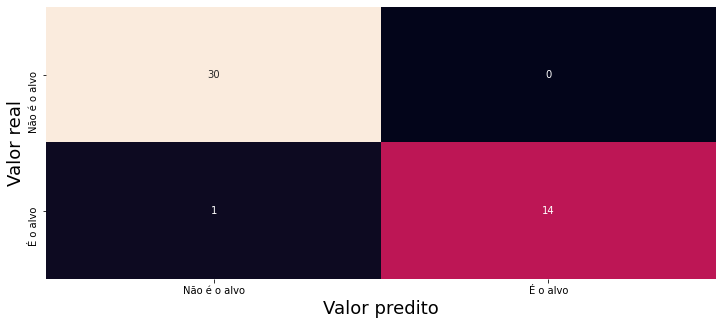

In [16]:
# Matriz de confusão
plt.subplots(figsize=(12,5))
cmat = confusion_matrix(y_real_test, y_pred_test)

axis_label = ['Não é o alvo', 'É o alvo']

sns.heatmap(cmat, annot=True, cbar=False, xticklabels=axis_label, yticklabels=axis_label);
plt.xlabel('Valor predito', fontsize='18');
plt.ylabel('Valor real', fontsize='18');


In [17]:
#Salvar modelo
#best_model.save('modelo_mfcc')

INFO:tensorflow:Assets written to: modelo_mfcc\assets
